First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [70]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [71]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [72]:
executed_by ='stud-id_52253331'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [73]:
# group id for this project
group_id = '05'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_52253331'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12426894'  # Replace the digits after "id_" with student B's student ID

In [74]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [75]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [76]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [77]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [78]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Ana" .',
f':{student_a} foaf:familyName "Zrnic" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> "{student_a}" .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "52253331"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Daria" .',
f':{student_b} foaf:familyName "Alekseienkova" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> "{student_b}" .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12426894"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [79]:
#weather_data_path = os.path.join("data", "datasets", "weather")
marketing_data_path = os.path.join("data", "datasets", "ifood")

def load_marketing_data():
    input_file = os.path.join(marketing_data_path, "ml_project1_data.csv")   # change name if needed
    df = pd.read_csv(input_file)
    # Example: print first rows
    display(df.head())
    return df
start_time_ld = now()
ifood_df = load_marketing_data()
end_time_ld = now()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Business Understanding 

In [80]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [81]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
This dataset was taken form the website Kaggle. It is a dataset that contains transactional and demographic information about customers of Ifood, a Brazilian online ordering and delivery platform.
The dataset originally comes from a public github repository when the Ifood Brain team had a data challenge for the data analyst role hiring process.
The company wants to understand the spending behavior of its customers to improve effectivness of marketing campaigns with historical customer interactions and their past spending patterns.
In order to achieve this, we are building a data-driven approach using data mining techniques to analyze customer data and identify patterns and trends in their spending behavior.
"""

business_objectives_comment = """
The primary business objective of the customer is to predict how much a customer is likely to spend, in order to imporve marketing strategies.
This allows for better targeting, bugdet allocation and campaing planning.
Key business questions: 
- Which variables (behavioral or demographic) are more significant in predicting customer spending?
- How much is a customer expected to spend based on their profile and past interactions?
"""

business_success_criteria_comment = """
Business success is achieved if the implemented prediction model improves the marketing team's effectiveness in targeting customers and allocating budgets.
Measurable criteria:
-Identify the top 20%% of customers who are the highest spenders before launching a new campaign.
-Increase revenue by 6%% in the next quarter compared to the previous quarter by targeting high-spending customers.
-Reduce marketing costs by at least 13%% on customers who are inactive.

Subjective criteria:
- The model's insights and predictions are positively received and understandable by the marketing team and marketing managers.
- The model is stable and doesn't drastically change within smaller time frames, which the stakeholders would find reassuring.
"""

data_mining_goals_comment = """
To support the business objectives, a regression model will be developed to predict customer spending, and to identify which features most strongly influence that spending.
The outputs of the data mining process will include:
- Predicted spending value per customer
- A ranked list of significant features influencing customer spending

What is not part of our data mining goals:
- Not predicting campaign success probability
"""

data_mining_success_criteria_comment = """
A successful outcome requires that the regression model achieves acceptable predictive performance, as measured by the following criteria:
- The coefficient of determination (R^2) is at least 0.65, indicating that a significant amount of the variance is explained by the input features.
- The Mean Absolute Error (MAE) value is below 15%% of the average spending value.
- The Root Mean Squared Error (RMSE) value is below 10%% of the average spending value.
"""

ai_risk_aspects_comment = """
According to the EU AI Regulation risk classification, this project falls under the 'minimal or no risk' category.
The dataset contains no sensitive personal or biometric data, reducing the potential for discrimination or harm, it is used exclusively for analytical purposes to improve marketing strategies.
No special regulatory requirements are applicable, beyond standard data protection and transparency practices to avoid bias.
"""


bu_ass_uuid_executor = "9ed892e7-26e2-44e7-b512-f17b1c37bede" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [82]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


In [83]:
start_time_at = now()

attribute_types = ifood_df.dtypes.astype(str)
display(attribute_types)

raw_mapping = """
ID                       nominal
Year_Birth               interval
Education                ordinal
Marital_Status           nominal
Income                   ratio
Kidhome                  ratio
Teenhome                 ratio
Dt_Customer              interval
Recency                  ratio
MntWines                 ratio
MntFruits                ratio
MntMeatProducts          ratio
MntFishProducts          ratio
MntSweetProducts         ratio
MntGoldProds             ratio
NumDealsPurchases        ratio
NumWebPurchases          ratio
NumCatalogPurchases      ratio
NumStorePurchases        ratio
NumWebVisitsMonth        ratio
AcceptedCmp3             nominal-binary
AcceptedCmp4             nominal-binary
AcceptedCmp5             nominal-binary
AcceptedCmp1             nominal-binary
AcceptedCmp2             nominal-binary
Complain                 nominal-binary
Z_CostContact            unknown
Z_Revenue                unknown
Response                 nominal-binary
"""

mapping_dict = {}
for line in raw_mapping.strip().split("\n"):
    parts = line.split()
    attribute = parts[0]
    measurement = parts[-1]
    mapping_dict[attribute] = measurement

mapping_df = pd.DataFrame.from_dict(mapping_dict, orient='index', columns=['Measurement_Level'])
mapping_df = mapping_df.reset_index().rename(columns={'index': 'Attribute'})

# Create a combined view with data types and measurement levels
data_types_df = pd.DataFrame({
    'Attribute': ifood_df.columns,
    'Data_Type': ifood_df.dtypes.astype(str).values
})
data_types_df = data_types_df.merge(mapping_df, on='Attribute', how='left')
display(data_types_df)
end_time_at = now()

#############################################
# Documentation: Load Data Activity
#############################################

ld_ass_uuid_executor = "bf9b0720-992f-47e8-ac7f-69a60fb6d30f"
load_data_code_writer = student_a

load_data_activity = [
    f':load_data rdf:type prov:Activity .',
    f':load_data sc:isPartOf :data_understanding_phase .',
    f':load_data rdfs:label "Load Marketing Data" .',
    f':load_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_data_activity, prefixes=prefixes)

#############################################
# Documentation: Attribute Types Activity
#############################################

attribute_types_code_writer = student_a
at_ass_uuid_executor = "ecc01d19-5c60-4111-b6f5-41de2174034a"  # Generate once
at_ass_uuid_writer = "c649f647-b22d-4831-a27f-27ade3777a1b"  # Generate once

at_comment = """
Analysis of attribute types in the iFood marketing dataset. Each attribute was classified as: nominal, ordinal, interval or ratio based on the nature of the data:
- Nominal: Categorical variables without inherent order (e.g., ID, Marital_Status)
- Ordinal: Categorical variables with meaningful order (e.g., Education)
- Interval: Numeric variables with meaningful differences but no true zero (e.g., Year_Birth, Dt_Customer)
- Ratio: Numeric variables with true zero point (e.g., Income, spending amounts, counts)
- Nominal-binary: Binary categorical variables (e.g., campaign acceptance flags, Complain, Response)
"""

# Document the attribute types activity
attribute_types_activity = [
    f':identify_attribute_types rdf:type prov:Activity .',
    f':identify_attribute_types sc:isPartOf :data_understanding_phase .',
    f':identify_attribute_types rdfs:label "Identify Attribute Types" .',
    f':identify_attribute_types rdfs:comment """{at_comment}""" .',
    f':identify_attribute_types prov:startedAtTime "{start_time_at}"^^xsd:dateTime .',
    f':identify_attribute_types prov:endedAtTime "{end_time_at}"^^xsd:dateTime .',
    
    # Executor association
    f':identify_attribute_types prov:qualifiedAssociation :{at_ass_uuid_executor} .',
    f':{at_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{at_ass_uuid_executor} rdf:type prov:Association .',
    f':{at_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':identify_attribute_types prov:qualifiedAssociation :{at_ass_uuid_writer} .',
    f':{at_ass_uuid_writer} prov:agent :{attribute_types_code_writer} .',
    f':{at_ass_uuid_writer} rdf:type prov:Association .',
    f':{at_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':identify_attribute_types prov:used :raw_data .',
    
    # Output: attribute types report entity
    f':attribute_types_report rdf:type prov:Entity .',
    f':attribute_types_report prov:wasGeneratedBy :identify_attribute_types .',
    f':attribute_types_report rdfs:label "Attribute Types Classification Report" .',
    f':attribute_types_report rdfs:comment "Classification of 29 attributes into measurement scales: nominal, ordinal, interval, ratio, and nominal-binary." .',
]
engine.insert(attribute_types_activity, prefixes=prefixes)

# Document measurement level statistics
measurement_counts = mapping_df['Measurement_Level'].value_counts().to_dict()
measurement_stats_comment = f"""
Measurement level distribution:
- Ratio: {measurement_counts.get('ratio', 0)} attributes (numeric with true zero)
- Nominal-binary: {measurement_counts.get('nominal-binary', 0)} attributes (binary flags)
- Nominal: {measurement_counts.get('nominal', 0)} attributes (categorical without order)
- Interval: {measurement_counts.get('interval', 0)} attributes (numeric without true zero)
- Ordinal: {measurement_counts.get('ordinal', 0)} attributes (categorical with order)
- Unknown: {measurement_counts.get('unknown', 0)} attributes (to be investigated)
"""

attribute_types_stats = [
    f':attribute_types_statistics rdf:type prov:Entity .',
    f':attribute_types_statistics prov:wasGeneratedBy :identify_attribute_types .',
    f':attribute_types_statistics prov:wasDerivedFrom :attribute_types_report .',
    f':attribute_types_statistics rdfs:label "Attribute Types Statistics" .',
    f':attribute_types_statistics rdfs:comment """{measurement_stats_comment}""" .',
]
engine.insert(attribute_types_stats, prefixes=prefixes)

print("Attribute types documentation inserted successfully.")


ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

,Attribute,Data_Type,Measurement_Level
0,ID,int64,nominal
1,Year_Birth,int64,interval
2,Education,object,ordinal
3,Marital_Status,object,nominal
4,Income,float64,ratio
5,Kidhome,int64,ratio
6,Teenhome,int64,ratio
7,Dt_Customer,object,interval
8,Recency,int64,ratio
9,MntWines,int64,ratio


Attribute types documentation inserted successfully.


In [84]:

def infer_unit(col, series):
    col_lower = col.lower()

    if series.dropna().nunique() == 2 and set(series.dropna().unique()).issubset({0,1}):
        return "binary indicator (0/1)"

    if "date" in col_lower or "dt" in col_lower:
        return "calendar date (YYYY-MM-DD)"

    if "recency" in col_lower:
        return "days"

    if any(x in col_lower for x in ["mnt", "meat", "fish", "wine", "fruits", "gold", "sweet"]):
        return "monetary amount (EUR)"

    if col_lower.startswith("num") or "visits" in col_lower or "purchases" in col_lower:
        return "count"

    if "kid" in col_lower or "teen" in col_lower or col_lower.endswith("home"):
        return "count of people"

    if "income" in col_lower:
        return "yearly income (EUR)"

    #Synthetic fields Z_CostContact / Z_Revenue (from marketing cost model)
    if col_lower.startswith("z_"):
        return "synthetic score (unit unspecified)"

    if col_lower == "id":
        return "identifier (no unit)"

    if "year_birth" in col_lower:
        return "year"

    # fallback: numeric unitless
    if np.issubdtype(series.dropna().dtype, np.number):
        return "unitless numeric value"

    # fallback for categorical
    return "categorical label (no unit)"


start_time_iu = now()

# apply the function to every column
units = {col: infer_unit(col, ifood_df[col]) for col in ifood_df.columns}

units_df = pd.DataFrame(list(units.items()), columns=["Attribute", "Unit"])
print(units_df)
end_time_iu = now()

#############################################
# Documentation: Identify Attribute Units Activity
#############################################



identify_units_code_writer = student_a
iu_ass_uuid_executor = "5340c3df-80c1-4de9-bd13-cf287c721bf8"  # Generate once
iu_ass_uuid_writer = "c92dfc00-457f-4ee1-ae23-c861675f95cc"  # Generate once

iu_comment = """
Analysis of attribute units in the iFood marketing dataset. Each attribute was assigned a unit based on its semantic meaning:
- Identifier: ID column with no unit
- Year: Birth year
- Calendar date: Customer enrollment date
- Days: Time since last purchase (recency)
- Monetary amount (EUR): All spending columns (wines, fruits, meat, fish, sweets, gold)
- Count: Number of purchases, deals, web visits
- Count of people: Number of kids/teens at home
- Yearly income (EUR): Customer income
- Binary indicator (0/1): Campaign acceptance flags, complain, response
- Synthetic score: Z_CostContact and Z_Revenue (marketing model scores)
- Categorical label: Education and Marital_Status
"""

identify_units_activity = [
    f':identify_attribute_units rdf:type prov:Activity .',
    f':identify_attribute_units sc:isPartOf :data_understanding_phase .',
    f':identify_attribute_units rdfs:label "Identify Attribute Units" .',
    f':identify_attribute_units rdfs:comment """{iu_comment}""" .',
    f':identify_attribute_units prov:startedAtTime "{start_time_iu}"^^xsd:dateTime .',
    f':identify_attribute_units prov:endedAtTime "{end_time_iu}"^^xsd:dateTime .',
    
    # Executor association
    f':identify_attribute_units prov:qualifiedAssociation :{iu_ass_uuid_executor} .',
    f':{iu_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{iu_ass_uuid_executor} rdf:type prov:Association .',
    f':{iu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':identify_attribute_units prov:qualifiedAssociation :{iu_ass_uuid_writer} .',
    f':{iu_ass_uuid_writer} prov:agent :{identify_units_code_writer} .',
    f':{iu_ass_uuid_writer} rdf:type prov:Association .',
    f':{iu_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':identify_attribute_units prov:used :raw_data .',
    
    # Output: attribute units report entity
    f':attribute_units_report rdf:type prov:Entity .',
    f':attribute_units_report prov:wasGeneratedBy :identify_attribute_units .',
    f':attribute_units_report rdfs:label "Attribute Units Classification Report" .',
    f':attribute_units_report rdfs:comment "Classification of 29 attributes with their respective units and measurement semantics." .',
]
engine.insert(identify_units_activity, prefixes=prefixes)

print("Attribute units documentation inserted successfully.")


              Attribute                                Unit
0                    ID                identifier (no unit)
1            Year_Birth                                year
2             Education         categorical label (no unit)
3        Marital_Status         categorical label (no unit)
4                Income                 yearly income (EUR)
5               Kidhome                     count of people
6              Teenhome                     count of people
7           Dt_Customer          calendar date (YYYY-MM-DD)
8               Recency                                days
9              MntWines               monetary amount (EUR)
10            MntFruits               monetary amount (EUR)
11      MntMeatProducts               monetary amount (EUR)
12      MntFishProducts               monetary amount (EUR)
13     MntSweetProducts               monetary amount (EUR)
14         MntGoldProds               monetary amount (EUR)
15    NumDealsPurchases                 

In [85]:
# Dictionary of attribute semantics for ml_project1_data.csv

start_time_as = now()

attribute_semantics = {
    "ID": "Unique customer identifier.",
    "Year_Birth": "Customer's year of birth.",
    "Education": "Customer's highest education level.",
    "Marital_Status": "Customer's marital status.",
    "Income": "Annual household income of the customer.",
    "Kidhome": "Number of children living in the customer's household.",
    "Teenhome": "Number of teenagers living in the customer's household.",
    "Dt_Customer": "Date when the customer first enrolled with the company.",
    "Recency": "Number of days since the customer's last purchase.",
    "MntWines": "Amount spent on wine products in the last 2 years.",
    "MntFruits": "Amount spent on fruit products in the last 2 years.",
    "MntMeatProducts": "Amount spent on meat products in the last 2 years.",
    "MntFishProducts": "Amount spent on fish products in the last 2 years.",
    "MntSweetProducts": "Amount spent on sweet products in the last 2 years.",
    "MntGoldProds": "Amount spent on luxury ('gold') products in the last 2 years.",
    "NumDealsPurchases": "Number of purchases made using discounts.",
    "NumWebPurchases": "Number of purchases made through the company website.",
    "NumCatalogPurchases": "Number of purchases made via catalog orders.",
    "NumStorePurchases": "Number of purchases made in physical stores.",
    "NumWebVisitsMonth": "Number of website visits in the last month.",
    "AcceptedCmp3": "Whether the customer accepted the 3rd campaign (0/1).",
    "AcceptedCmp4": "Whether the customer accepted the 4th campaign (0/1).",
    "AcceptedCmp5": "Whether the customer accepted the 5th campaign (0/1).",
    "AcceptedCmp1": "Whether the customer accepted the 1st campaign (0/1).",
    "AcceptedCmp2": "Whether the customer accepted the 2nd campaign (0/1).",
    "Complain": "Whether the customer had a complaint in the last 2 years.",
    "Z_CostContact": "Administrative constant related to contact cost (no analytical meaning).",
    "Z_Revenue": "Administrative constant related to revenue baseline (no analytical meaning).",
    "Response": "Whether the customer accepted the most recent marketing campaign.",
}
attribute_semantics
end_time_as = now()

#############################################
# Documentation: Attribute Semantics Activity
#############################################

attribute_semantics_code_writer = student_a
as_ass_uuid_executor = "c4152613-f7fd-4898-bd4f-aad6c892e234"  # Generate once
as_ass_uuid_writer = "f50bf4ae-6548-42fa-9592-6ec9e9508b9e"  # Generate once

as_comment = f"""
Documentation of attribute semantics for the iFood marketing dataset:
{chr(10).join(f'- {k}: {v}' for k, v in attribute_semantics.items())}
"""

# Document the attribute semantics activity
attribute_semantics_activity = [
    f':identify_attribute_semantics rdf:type prov:Activity .',
    f':identify_attribute_semantics sc:isPartOf :data_understanding_phase .',
    f':identify_attribute_semantics rdfs:label "Identify Attribute Semantics" .',
    f':identify_attribute_semantics rdfs:comment """{as_comment}""" .',
    f':identify_attribute_semantics prov:startedAtTime "{start_time_as}"^^xsd:dateTime .',
    f':identify_attribute_semantics prov:endedAtTime "{end_time_as}"^^xsd:dateTime .',
    
    # Executor association
    f':identify_attribute_semantics prov:qualifiedAssociation :{as_ass_uuid_executor} .',
    f':{as_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{as_ass_uuid_executor} rdf:type prov:Association .',
    f':{as_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':identify_attribute_semantics prov:qualifiedAssociation :{as_ass_uuid_writer} .',
    f':{as_ass_uuid_writer} prov:agent :{attribute_semantics_code_writer} .',
    f':{as_ass_uuid_writer} rdf:type prov:Association .',
    f':{as_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':identify_attribute_semantics prov:used :raw_data .',
    
    # Output: attribute semantics report entity
    f':attribute_semantics_report rdf:type prov:Entity .',
    f':attribute_semantics_report prov:wasGeneratedBy :identify_attribute_semantics .',
    f':attribute_semantics_report rdfs:label "Attribute Semantics Report" .',
    f':attribute_semantics_report rdfs:comment "Business context and semantic descriptions for all 29 attributes in the dataset." .',
]
engine.insert(attribute_semantics_activity, prefixes=prefixes)

# Create a combined semantics dataframe for display
semantics_df = pd.DataFrame(list(attribute_semantics.items()), columns=["Attribute", "Semantic_Description"])
display(semantics_df)

print("Attribute semantics documentation inserted successfully.")


,Attribute,Semantic_Description
0,ID,Unique customer identifier.
1,Year_Birth,Customer's year of birth.
2,Education,Customer's highest education level.
3,Marital_Status,Customer's marital status.
4,Income,Annual household income of the customer.
5,Kidhome,Number of children living in the customer's household.
6,Teenhome,Number of teenagers living in the customer's household.
7,Dt_Customer,Date when the customer first enrolled with the company.
8,Recency,Number of days since the customer's last purchase.
9,MntWines,Amount spent on wine products in the last 2 years.


Attribute semantics documentation inserted successfully.


In [86]:
numeric_cols = [
    "Year_Birth", "Income", "Kidhome", "Teenhome", "Recency",
    "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts",
    "MntSweetProducts", "MntGoldProds",
    "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases",
    "NumStorePurchases", "NumWebVisitsMonth"
]
start_time_bs = now()

basic_stats = pd.DataFrame({
    "mean": ifood_df[numeric_cols].mean(),
    "median": ifood_df[numeric_cols].median(),
    "min": ifood_df[numeric_cols].min(),
    "max": ifood_df[numeric_cols].max(),
    "variance": ifood_df[numeric_cols].var(),
    "std_dev": ifood_df[numeric_cols].std(),
    "skewness": ifood_df[numeric_cols].skew(),
    "mode": ifood_df[numeric_cols].mode().iloc[0]
})

print("\n=== BASIC STATISTICS FOR NUMERIC ATTRIBUTES ===")
display(basic_stats)

end_time_bs = now()
#############################################
# Documentation: Basic Statistics Activity
#############################################

basic_stats_code_writer = student_a
bs_ass_uuid_executor = "ecfbbc77-6e6e-4f13-af4c-8967c112e3cd"  # Generate once
bs_ass_uuid_writer = "edd8ec45-40ce-4ba3-ae61-6ecd894c7632"  # Generate once

bs_comment = """
Computed basic descriptive statistics for 16 numeric attributes in the iFood marketing dataset:
- Central tendency: mean, median, mode
- Dispersion: variance, standard deviation, min, max
- Shape: skewness
These statistics help understand the distribution and identify potential data quality issues.
"""

basic_stats_activity = [
    f':compute_basic_statistics rdf:type prov:Activity .',
    f':compute_basic_statistics sc:isPartOf :data_understanding_phase .',
    f':compute_basic_statistics rdfs:label "Compute Basic Statistics" .',
    f':compute_basic_statistics rdfs:comment """{bs_comment}""" .',
    f':compute_basic_statistics prov:startedAtTime "{start_time_bs}"^^xsd:dateTime .',
    f':compute_basic_statistics prov:endedAtTime "{end_time_bs}"^^xsd:dateTime .',
    
    # Executor association
    f':compute_basic_statistics prov:qualifiedAssociation :{bs_ass_uuid_executor} .',
    f':{bs_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{bs_ass_uuid_executor} rdf:type prov:Association .',
    f':{bs_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':compute_basic_statistics prov:qualifiedAssociation :{bs_ass_uuid_writer} .',
    f':{bs_ass_uuid_writer} prov:agent :{basic_stats_code_writer} .',
    f':{bs_ass_uuid_writer} rdf:type prov:Association .',
    f':{bs_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':compute_basic_statistics prov:used :raw_data .',
    
    # Output: basic statistics report entity
    f':basic_statistics_report rdf:type prov:Entity .',
    f':basic_statistics_report prov:wasGeneratedBy :compute_basic_statistics .',
    f':basic_statistics_report rdfs:label "Basic Statistics Report" .',
    f':basic_statistics_report rdfs:comment "Descriptive statistics (mean, median, min, max, variance, std_dev, skewness, mode) for 16 numeric attributes." .',
]
engine.insert(basic_stats_activity, prefixes=prefixes)

print("Basic statistics documentation inserted successfully.")



=== BASIC STATISTICS FOR NUMERIC ATTRIBUTES ===


,mean,median,min,max,variance,std_dev,skewness,mode
Year_Birth,1968.805804,1970.0,1893.0,1996.0,1.436179e+02,11.984069,-0.349944,1976.0
Income,52247.251354,51381.5,1730.0,666666.0,6.336838e+08,25173.076661,6.763487,7500.0
Kidhome,0.444196,0.0,0.0,2.0,2.898725e-01,0.538398,0.635288,0.0
Teenhome,0.506250,0.0,0.0,2.0,2.965219e-01,0.544538,0.407115,0.0
Recency,49.109375,49.0,0.0,99.0,8.388237e+02,28.962453,-0.001987,56.0
MntWines,303.935714,173.5,0.0,1493.0,1.132978e+05,336.597393,1.175771,2.0
MntFruits,26.302232,8.0,0.0,199.0,1.581926e+03,39.773434,2.102063,0.0
MntMeatProducts,166.950000,67.0,0.0,1725.0,5.094743e+04,225.715373,2.083233,7.0
MntFishProducts,37.525446,12.0,0.0,259.0,2.984325e+03,54.628979,1.919769,0.0
MntSweetProducts,27.062946,8.0,0.0,263.0,1.704080e+03,41.280498,2.136081,0.0


Basic statistics documentation inserted successfully.


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
Year_Birth,1.000000,-0.161791,0.230176,-0.352111,-0.019871,-0.157773,-0.017917,-0.030872,-0.041625,-0.018133,-0.061818,-0.060846,-0.145040,-0.121275,-0.128272,0.121139
Income,-0.161791,1.000000,-0.428669,0.019133,-0.003970,0.578650,0.430842,0.584633,0.438871,0.440744,0.325916,-0.083101,0.387878,0.589162,0.529362,-0.553088
Kidhome,0.230176,-0.428669,1.000000,-0.036133,0.008827,-0.496297,-0.372581,-0.437129,-0.387644,-0.370673,-0.349595,0.221798,-0.361647,-0.502237,-0.499683,0.447846
Teenhome,-0.352111,0.019133,-0.036133,1.000000,0.016198,0.004846,-0.176764,-0.261160,-0.204187,-0.162475,-0.021725,0.387741,0.155500,-0.110769,0.050695,0.134884
Recency,-0.019871,-0.003970,0.008827,0.016198,1.000000,0.016064,-0.004306,0.023056,0.001079,0.022670,0.016693,-0.001098,-0.010726,0.025110,0.000799,-0.021445
MntWines,-0.157773,0.578650,-0.496297,0.004846,0.016064,1.000000,0.389637,0.562667,0.399753,0.386581,0.387516,0.010940,0.542265,0.635226,0.642100,-0.320653
MntFruits,-0.017917,0.430842,-0.372581,-0.176764,-0.004306,0.389637,1.000000,0.543105,0.594804,0.567164,0.392995,-0.132114,0.296735,0.487917,0.461758,-0.418383
MntMeatProducts,-0.030872,0.584633,-0.437129,-0.261160,0.023056,0.562667,0.543105,1.000000,0.568402,0.523846,0.350609,-0.122415,0.293761,0.723827,0.479659,-0.539470
MntFishProducts,-0.041625,0.438871,-0.387644,-0.204187,0.001079,0.399753,0.594804,0.568402,1.000000,0.579870,0.422875,-0.139361,0.293681,0.534478,0.459855,-0.446003
MntSweetProducts,-0.018133,0.440744,-0.370673,-0.162475,0.022670,0.386581,0.567164,0.523846,0.579870,1.000000,0.369724,-0.120100,0.348544,0.490924,0.448756,-0.423294


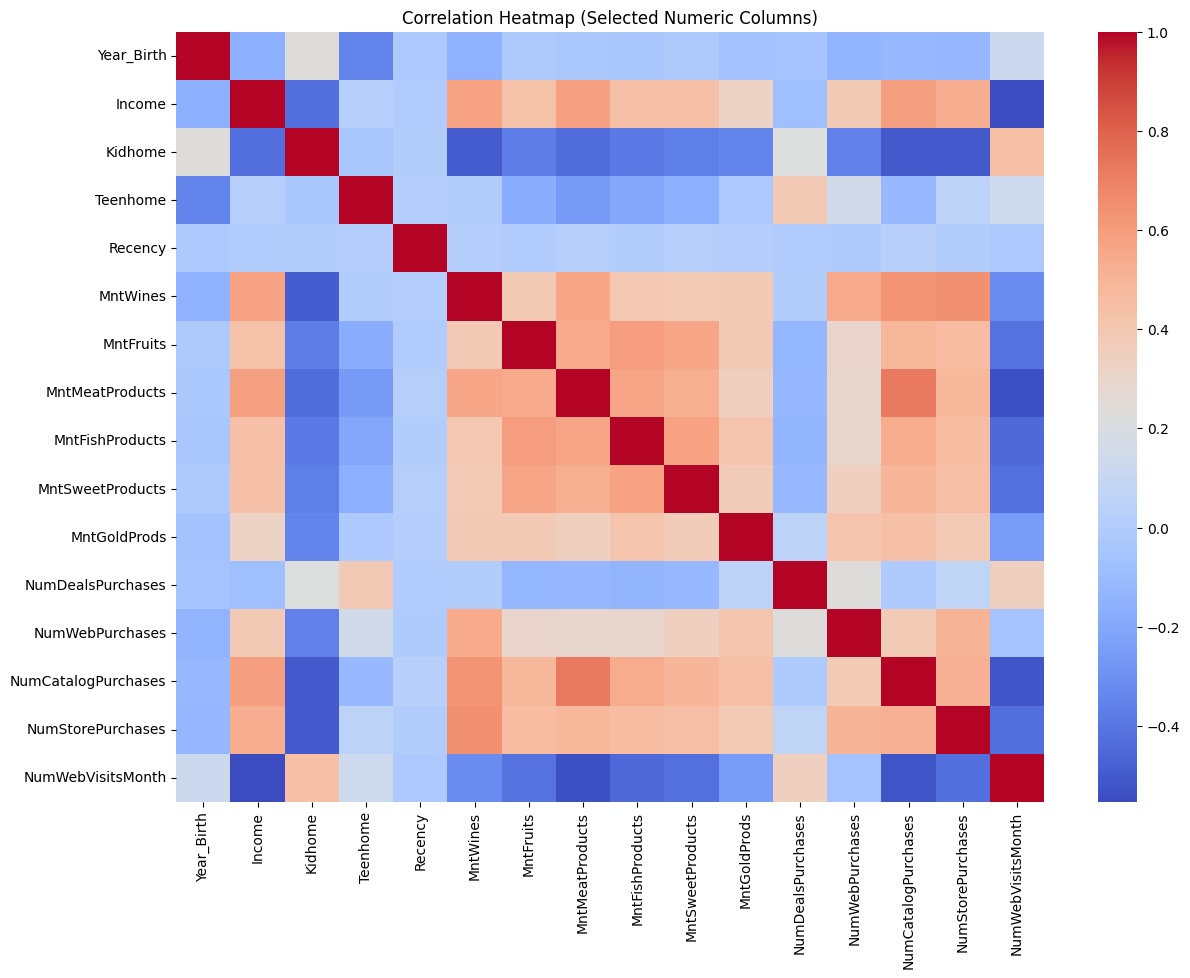

Correlation analysis documentation inserted successfully.


In [87]:
import seaborn as sns

start_time_corr = now()

corr_matrix = ifood_df[numeric_cols].corr()
display(corr_matrix)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Selected Numeric Columns)")
plt.show()

end_time_corr = now()
#############################################
# Documentation: Correlation Analysis Activity
#############################################


correlation_code_writer = student_a
corr_ass_uuid_executor = "6e47c05d-e6bc-495a-9209-4b0213529c92"  # Generate once
corr_ass_uuid_writer = "e436bb3b-0ec2-4b07-b127-b61aafd8fd9f"  # Generate once

corr_comment = """
Computed Pearson correlation matrix for 16 numeric attributes in the iFood marketing dataset.
A correlation heatmap was generated to visualize relationships between variables.
Key observations:
- Spending variables (MntWines, MntMeatProducts, MntFishProducts, etc.) show positive correlations with each other
- Income shows positive correlation with spending amounts
- NumWebVisitsMonth may show negative correlation with some purchase channels
"""

correlation_activity = [
    f':compute_correlation rdf:type prov:Activity .',
    f':compute_correlation sc:isPartOf :data_understanding_phase .',
    f':compute_correlation rdfs:label "Compute Correlation Matrix" .',
    f':compute_correlation rdfs:comment """{corr_comment}""" .',
    f':compute_correlation prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':compute_correlation prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    
    # Executor association
    f':compute_correlation prov:qualifiedAssociation :{corr_ass_uuid_executor} .',
    f':{corr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{corr_ass_uuid_executor} rdf:type prov:Association .',
    f':{corr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':compute_correlation prov:qualifiedAssociation :{corr_ass_uuid_writer} .',
    f':{corr_ass_uuid_writer} prov:agent :{correlation_code_writer} .',
    f':{corr_ass_uuid_writer} rdf:type prov:Association .',
    f':{corr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':compute_correlation prov:used :raw_data .',
    
    # Output: correlation matrix entity
    f':correlation_matrix rdf:type prov:Entity .',
    f':correlation_matrix prov:wasGeneratedBy :compute_correlation .',
    f':correlation_matrix rdfs:label "Correlation Matrix" .',
    f':correlation_matrix rdfs:comment "Pearson correlation coefficients for 16 numeric attributes." .',
    
    # Output: correlation heatmap visualization
    f':correlation_heatmap rdf:type prov:Entity .',
    f':correlation_heatmap prov:wasGeneratedBy :compute_correlation .',
    f':correlation_heatmap rdfs:label "Correlation Heatmap Visualization" .',
    f':correlation_heatmap rdfs:comment "Heatmap visualization of the correlation matrix using seaborn." .',
]
engine.insert(correlation_activity, prefixes=prefixes)

print("Correlation analysis documentation inserted successfully.")

In [88]:
ifood_df["Age"] = 2025 - ifood_df["Year_Birth"]

sensitive_attributes = ["Income", "Age"]

print("\n correlation WITH Income AND Age (Bias Check)")
corr_sensitive = ifood_df[numeric_cols + ["Age"]].corr()[sensitive_attributes]
display(corr_sensitive)

start_time_bias = now()
end_time_bias = now()

#############################################
# Documentation: Bias Check Activity
#############################################

bias_check_code_writer = student_a
bias_ass_uuid_executor = "2c93eb73-ba03-4336-8d2a-a5b19fde27ef"  # Generate once
bias_ass_uuid_writer = "5a6e32f8-d310-4497-8245-e1a5676c7403"  # Generate once

bias_comment = """
Analyzed correlation between sensitive attributes (Income, Age) and other numeric features to check for potential bias.
Age was derived from Year_Birth (2025 - Year_Birth). This analysis helps identify if the model might be biased 
towards certain demographic groups based on income level or age.
"""

bias_check_activity = [
    f':check_bias_correlation rdf:type prov:Activity .',
    f':check_bias_correlation sc:isPartOf :data_understanding_phase .',
    f':check_bias_correlation rdfs:label "Check Bias Correlation" .',
    f':check_bias_correlation rdfs:comment """{bias_comment}""" .',
    f':check_bias_correlation prov:startedAtTime "{start_time_bias}"^^xsd:dateTime .',
    f':check_bias_correlation prov:endedAtTime "{end_time_bias}"^^xsd:dateTime .',
    
    # Executor association
    f':check_bias_correlation prov:qualifiedAssociation :{bias_ass_uuid_executor} .',
    f':{bias_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{bias_ass_uuid_executor} rdf:type prov:Association .',
    f':{bias_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':check_bias_correlation prov:qualifiedAssociation :{bias_ass_uuid_writer} .',
    f':{bias_ass_uuid_writer} prov:agent :{bias_check_code_writer} .',
    f':{bias_ass_uuid_writer} rdf:type prov:Association .',
    f':{bias_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':check_bias_correlation prov:used :raw_data .',
    
    # Output: bias correlation report
    f':bias_correlation_report rdf:type prov:Entity .',
    f':bias_correlation_report prov:wasGeneratedBy :check_bias_correlation .',
    f':bias_correlation_report rdfs:label "Bias Correlation Report" .',
    f':bias_correlation_report rdfs:comment "Correlation analysis between sensitive attributes (Income, Age) and numeric features." .',
]
engine.insert(bias_check_activity, prefixes=prefixes)

print("Bias check documentation inserted successfully.")


 correlation WITH Income AND Age (Bias Check)


,Income,Age
Year_Birth,-0.161791,-1.000000
Income,1.000000,0.161791
Kidhome,-0.428669,-0.230176
Teenhome,0.019133,0.352111
Recency,-0.003970,0.019871
MntWines,0.578650,0.157773
MntFruits,0.430842,0.017917
MntMeatProducts,0.584633,0.030872
MntFishProducts,0.438871,0.041625
MntSweetProducts,0.440744,0.018133


Bias check documentation inserted successfully.



⚠ Encoding Warnings for Year_Birth:
  - Contains extreme outliers (|z| > 4).
  - Contains impossible year values.


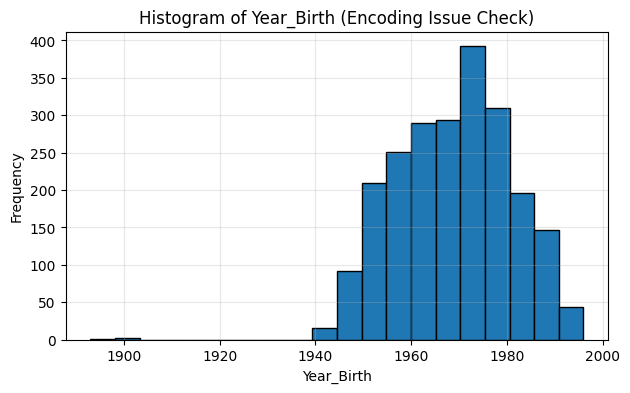


⚠ Encoding Warnings for Income:
  - Contains extreme outliers (|z| > 4).


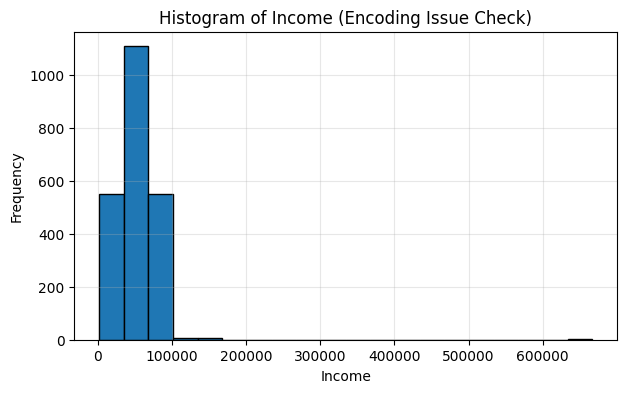


✓ No obvious encoding issues detected for Kidhome.


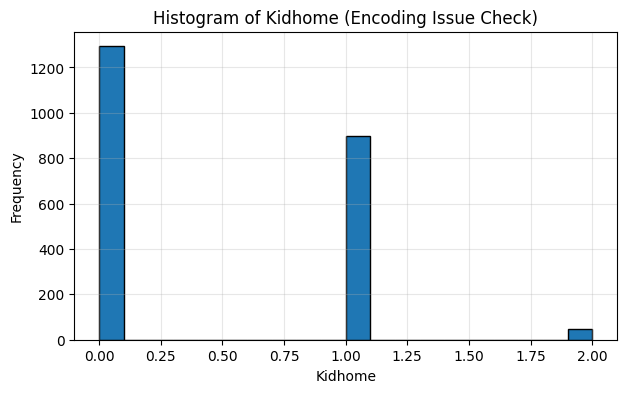


✓ No obvious encoding issues detected for Teenhome.


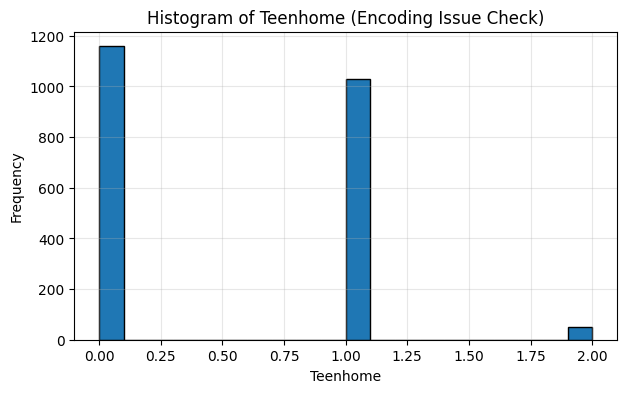


✓ No obvious encoding issues detected for Recency.


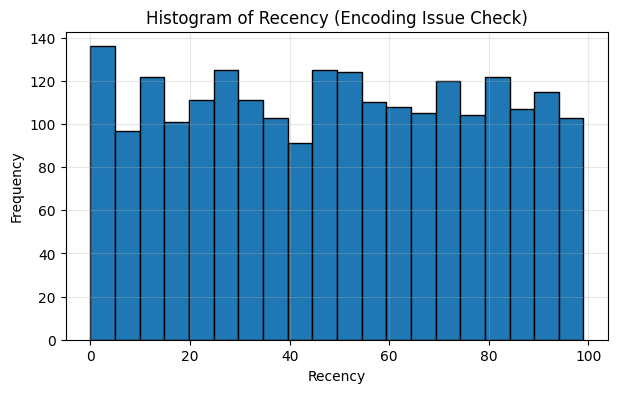


✓ No obvious encoding issues detected for MntWines.


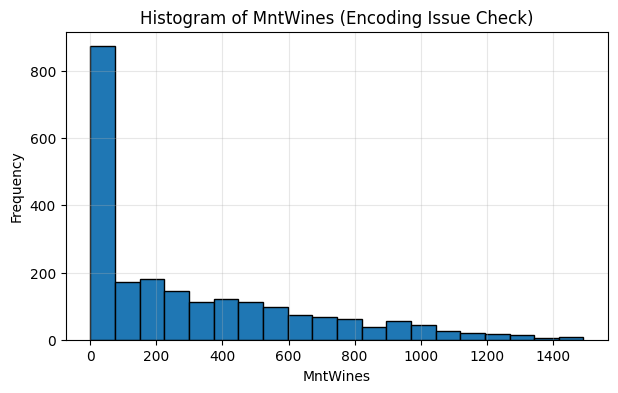


⚠ Encoding Warnings for MntFruits:
  - Contains extreme outliers (|z| > 4).


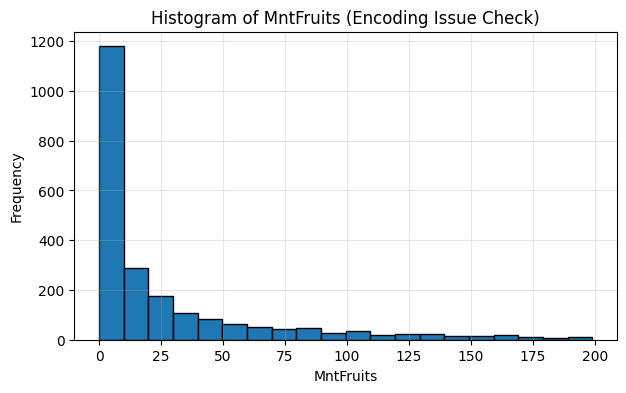


⚠ Encoding Warnings for MntMeatProducts:
  - Contains extreme outliers (|z| > 4).


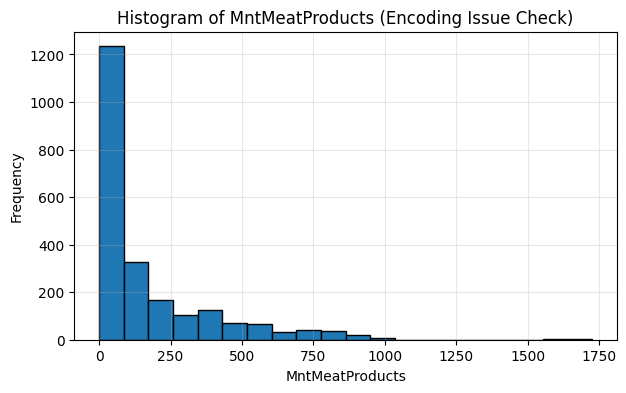


⚠ Encoding Warnings for MntFishProducts:
  - Contains extreme outliers (|z| > 4).


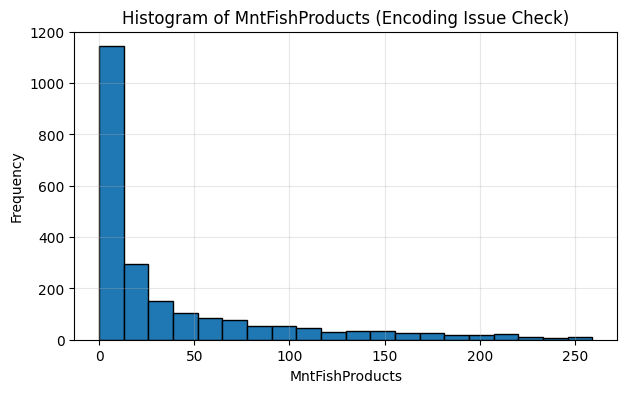


⚠ Encoding Warnings for MntSweetProducts:
  - Contains extreme outliers (|z| > 4).


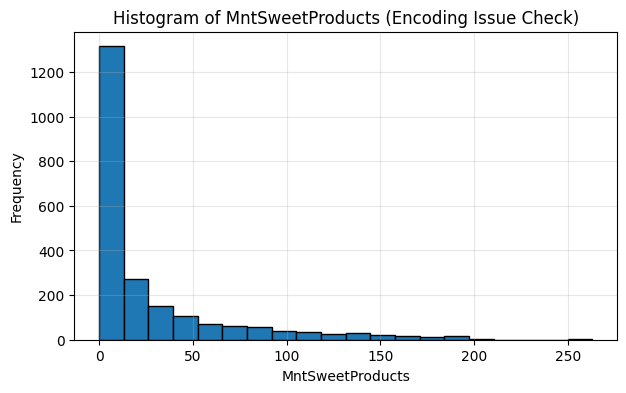


⚠ Encoding Warnings for MntGoldProds:
  - Contains extreme outliers (|z| > 4).


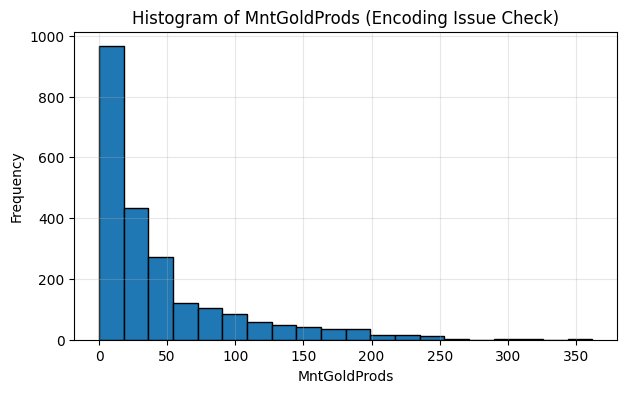


⚠ Encoding Warnings for NumDealsPurchases:
  - Contains extreme outliers (|z| > 4).


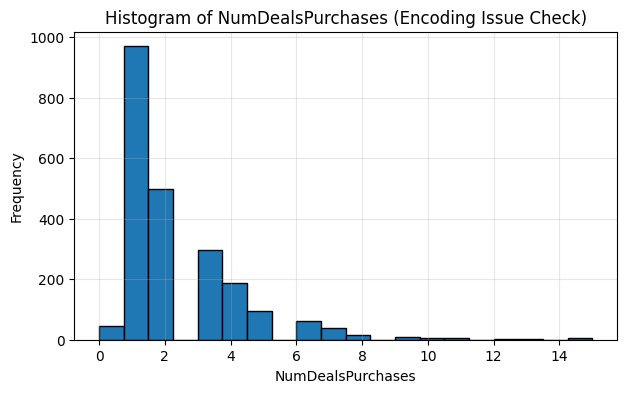


⚠ Encoding Warnings for NumWebPurchases:
  - Contains extreme outliers (|z| > 4).


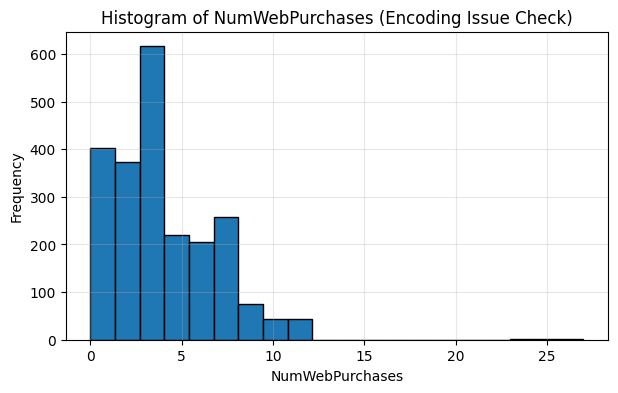


⚠ Encoding Warnings for NumCatalogPurchases:
  - Contains extreme outliers (|z| > 4).


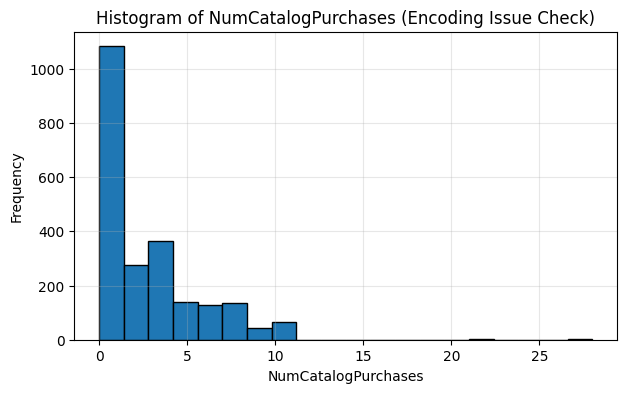


✓ No obvious encoding issues detected for NumStorePurchases.


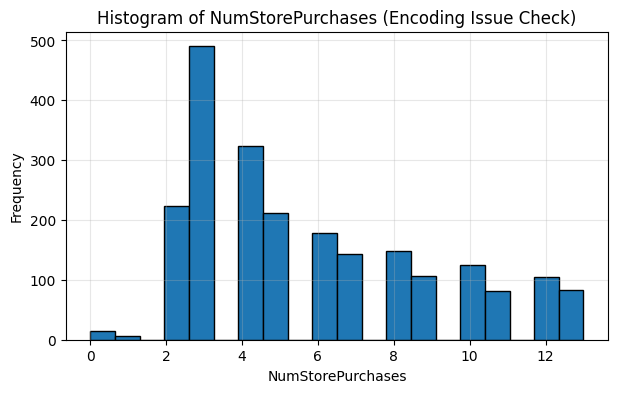


⚠ Encoding Warnings for NumWebVisitsMonth:
  - Contains extreme outliers (|z| > 4).


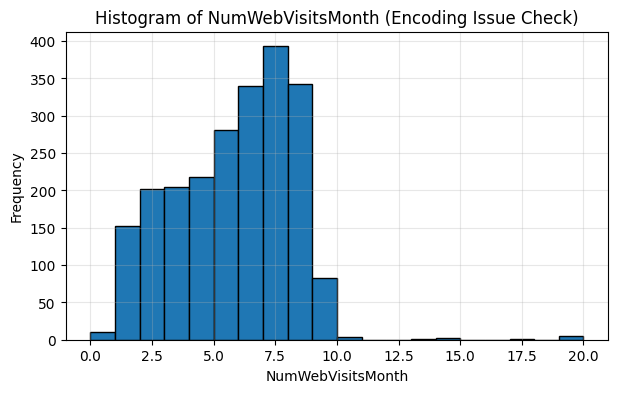

Histogram analysis documentation inserted successfully.


In [89]:
def plot_histogram_with_warnings(df, col):
    data = df[col].dropna()
    plt.figure(figsize=(7,4))
    plt.hist(data, bins=20, edgecolor='black')
    plt.title(f"Histogram of {col} (Encoding Issue Check)")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)

    # --- Encoding issue warnings ---
    warnings = []

    # Constant column
    if data.nunique() == 1:
        warnings.append("Column contains a single constant value.")

    # Check extreme outliers using z-score
    zscores = (data - data.mean()) / data.std()
    if (np.abs(zscores) > 4).any():
        warnings.append("Contains extreme outliers (|z| > 4).")

    # Impossible values based on variable name
    col_lower = col.lower()
    if "year" in col_lower and ((data < 1900).any() or (data > 2025).any()):
        warnings.append("Contains impossible year values.")
    if "income" in col_lower and (data < 0).any():
        warnings.append("Income cannot be negative.")

    # Print warnings under the plot
    if warnings:
        print(f"\n⚠ Encoding Warnings for {col}:")
        for w in warnings:
            print("  - " + w)
    else:
        print(f"\n✓ No obvious encoding issues detected for {col}.")

    plt.show()

start_time_hist = now()
# Run histogram diagnostics for each selected numeric column
for col in numeric_cols:
    plot_histogram_with_warnings(ifood_df, col)
end_time_hist = now()

#############################################
# Documentation: Histogram Analysis Activity
#############################################

histogram_code_writer = student_a
hist_ass_uuid_executor = "7122ad27-2d6b-4924-ba95-26135febfaec"  # Generate once
hist_ass_uuid_writer = "c6bbd564-7a94-4f98-9994-f835e0afc8ee"  # Generate once

hist_comment = """
Generated histograms for 16 numeric attributes to check for encoding issues and data quality problems.
Each histogram includes automated warnings for:
- Constant columns (single unique value)
- Extreme outliers (|z-score| > 4)
- Impossible year values (outside 1900-2025 range)
- Negative income values
This visual analysis helps identify potential data encoding errors before modeling.
"""

histogram_activity = [
    f':generate_histograms rdf:type prov:Activity .',
    f':generate_histograms sc:isPartOf :data_understanding_phase .',
    f':generate_histograms rdfs:label "Generate Histograms with Encoding Warnings" .',
    f':generate_histograms rdfs:comment """{hist_comment}""" .',
    f':generate_histograms prov:startedAtTime "{start_time_hist}"^^xsd:dateTime .',
    f':generate_histograms prov:endedAtTime "{end_time_hist}"^^xsd:dateTime .',
    
    # Executor association
    f':generate_histograms prov:qualifiedAssociation :{hist_ass_uuid_executor} .',
    f':{hist_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{hist_ass_uuid_executor} rdf:type prov:Association .',
    f':{hist_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':generate_histograms prov:qualifiedAssociation :{hist_ass_uuid_writer} .',
    f':{hist_ass_uuid_writer} prov:agent :{histogram_code_writer} .',
    f':{hist_ass_uuid_writer} rdf:type prov:Association .',
    f':{hist_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':generate_histograms prov:used :raw_data .',
    
    # Output: histogram visualizations
    f':histogram_visualizations rdf:type prov:Entity .',
    f':histogram_visualizations prov:wasGeneratedBy :generate_histograms .',
    f':histogram_visualizations rdfs:label "Histogram Visualizations with Encoding Warnings" .',
    f':histogram_visualizations rdfs:comment "16 histogram plots for numeric attributes with automated encoding issue detection." .',
]
engine.insert(histogram_activity, prefixes=prefixes)

print("Histogram analysis documentation inserted successfully.")

In [90]:
outlier_summary = {}

for col in numeric_cols:
    series = ifood_df[col]
    if series.std() == 0:
        continue  # no variation, skip outlier check
    z = (series - series.mean()) / series.std()
    outliers = (np.abs(z) > 4).sum()

    if outliers > 0:
        outlier_summary[col] = f"{outliers} extreme outliers detected (|z| > 4)."

print("\n=== Outlier Summary ===")
start_time_os = now()
outlier_summary
end_time_os = now()

#############################################
# Documentation: Outlier Summary Activity
#############################################

outlier_summary_code_writer = student_a
os_ass_uuid_executor = "0af419b9-5ed1-4f11-bcda-42a56ffeea88"  # Generate once
os_ass_uuid_writer = "6c82654e-0003-4ac0-a470-0885a9194eb5"  # Generate once

os_comment = """
Computed outlier summary for 16 numeric attributes using z-score method with threshold |z| > 4.
Identified extreme outliers that may indicate data quality issues or genuine extreme values.
This summary provides a quick overview of which columns contain statistical outliers.
"""

outlier_summary_activity = [
    f':compute_outlier_summary rdf:type prov:Activity .',
    f':compute_outlier_summary sc:isPartOf :data_understanding_phase .',
    f':compute_outlier_summary rdfs:label "Compute Outlier Summary" .',
    f':compute_outlier_summary rdfs:comment """{os_comment}""" .',
    f':compute_outlier_summary prov:startedAtTime "{start_time_os}"^^xsd:dateTime .',
    f':compute_outlier_summary prov:endedAtTime "{end_time_os}"^^xsd:dateTime .',
    
    # Executor association
    f':compute_outlier_summary prov:qualifiedAssociation :{os_ass_uuid_executor} .',
    f':{os_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{os_ass_uuid_executor} rdf:type prov:Association .',
    f':{os_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':compute_outlier_summary prov:qualifiedAssociation :{os_ass_uuid_writer} .',
    f':{os_ass_uuid_writer} prov:agent :{outlier_summary_code_writer} .',
    f':{os_ass_uuid_writer} rdf:type prov:Association .',
    f':{os_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':compute_outlier_summary prov:used :raw_data .',
    
    # Output: outlier summary report
    f':outlier_summary_report rdf:type prov:Entity .',
    f':outlier_summary_report prov:wasGeneratedBy :compute_outlier_summary .',
    f':outlier_summary_report rdfs:label "Outlier Summary Report" .',
    f':outlier_summary_report rdfs:comment """{json.dumps(outlier_summary, indent=2)}""" .',
]
engine.insert(outlier_summary_activity, prefixes=prefixes)

print("Outlier summary documentation inserted successfully.")


=== Outlier Summary ===
Outlier summary documentation inserted successfully.
Outlier summary documentation inserted successfully.


In [91]:
# Categorical attributes (object dtype)
categorical_cols = ifood_df.select_dtypes(include="object").columns.tolist()

# binary attributes (numeric columns with only {0,1})
binary_cols = [
    col for col in ifood_df.columns
    if ifood_df[col].dtype in ("int64", "float64")
    and set(ifood_df[col].dropna().unique()).issubset({0, 1})
]

categorical_like_cols = categorical_cols + binary_cols

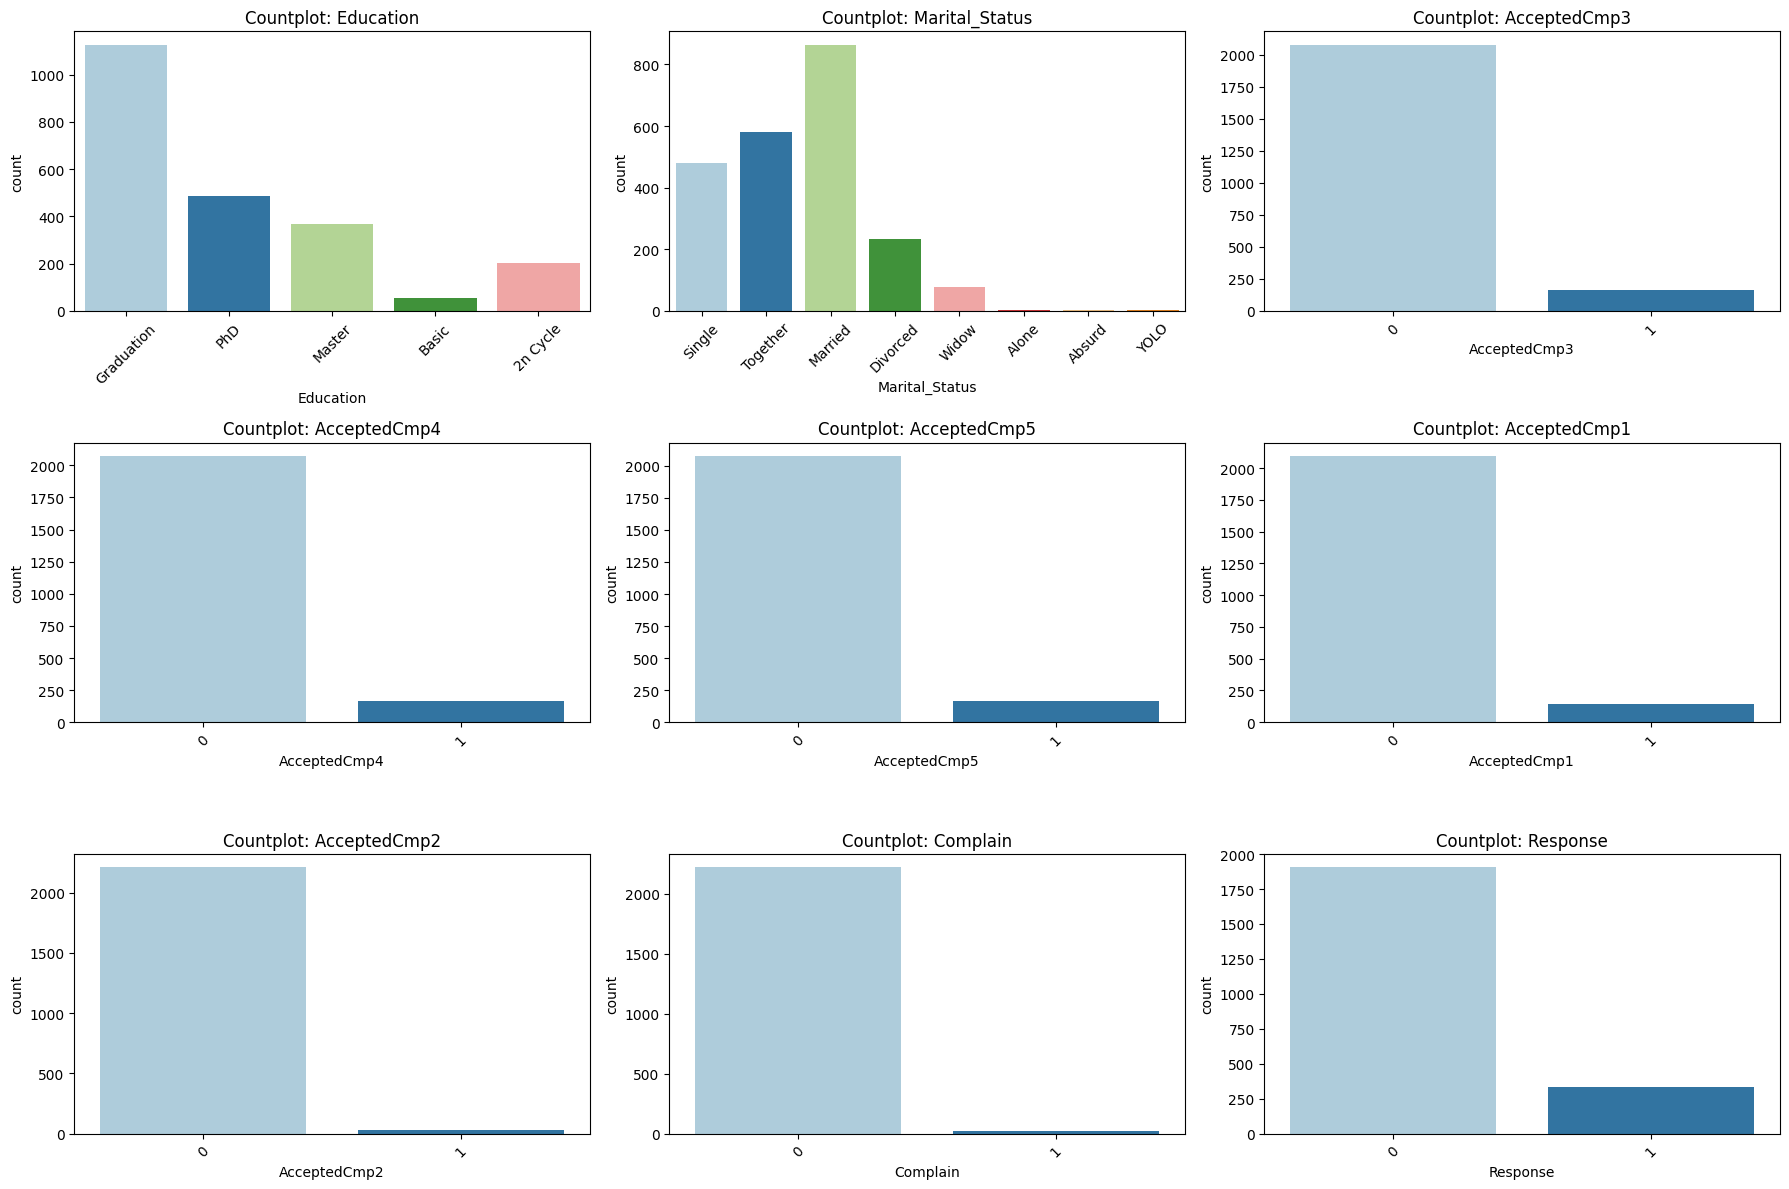

Categorical overview documentation inserted successfully.


In [92]:
categorical_like_cols = [c for c in (categorical_cols + binary_cols) if c != "Dt_Customer"]

def plot_categorical_overview(df, cols):
    n = len(cols)
    cols_per_row = 3
    rows = (n + cols_per_row - 1) // cols_per_row

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.countplot(x=df[col], ax=axes[i], hue=df[col], palette="Paired", legend=False)
        axes[i].set_title(f"Countplot: {col}")
        axes[i].tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

start_time_cat = now()
plot_categorical_overview(ifood_df, categorical_like_cols)
end_time_cat = now()


#############################################
# Documentation: Categorical Overview Activity
#############################################

categorical_overview_code_writer = student_a
cat_ass_uuid_executor = "5e823df6-1e13-4c71-abba-6225bb4cafac"  # Generate once
cat_ass_uuid_writer = "aa089fc2-f4c5-4e96-8596-486ed53d0258"  # Generate once

cat_comment = """
Generated countplots for categorical and binary attributes in the iFood marketing dataset.
Visualized the distribution of categories for Education, Marital_Status, and all binary campaign response flags.
Dt_Customer was excluded from visualization due to high cardinality (individual dates).
This analysis helps identify class imbalances and category distributions.
"""

categorical_overview_activity = [
    f':generate_categorical_overview rdf:type prov:Activity .',
    f':generate_categorical_overview sc:isPartOf :data_understanding_phase .',
    f':generate_categorical_overview rdfs:label "Generate Categorical Overview Plots" .',
    f':generate_categorical_overview rdfs:comment """{cat_comment}""" .',
    f':generate_categorical_overview prov:startedAtTime "{start_time_cat}"^^xsd:dateTime .',
    f':generate_categorical_overview prov:endedAtTime "{end_time_cat}"^^xsd:dateTime .',
    
    # Executor association
    f':generate_categorical_overview prov:qualifiedAssociation :{cat_ass_uuid_executor} .',
    f':{cat_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{cat_ass_uuid_executor} rdf:type prov:Association .',
    f':{cat_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':generate_categorical_overview prov:qualifiedAssociation :{cat_ass_uuid_writer} .',
    f':{cat_ass_uuid_writer} prov:agent :{categorical_overview_code_writer} .',
    f':{cat_ass_uuid_writer} rdf:type prov:Association .',
    f':{cat_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':generate_categorical_overview prov:used :raw_data .',
    
    # Output: categorical overview visualizations
    f':categorical_overview_visualizations rdf:type prov:Entity .',
    f':categorical_overview_visualizations prov:wasGeneratedBy :generate_categorical_overview .',
    f':categorical_overview_visualizations rdfs:label "Categorical Overview Countplots" .',
    f':categorical_overview_visualizations rdfs:comment "Countplot visualizations for {len(categorical_like_cols)} categorical and binary attributes." .',
]
engine.insert(categorical_overview_activity, prefixes=prefixes)

print("Categorical overview documentation inserted successfully.")


In [93]:
import re

def check_categorical_encoding(col, series):
    warnings = []

    # Convert to strings for uniform handling
    values = series.astype(str).str.strip()

    #placeholder values
    placeholder_patterns = ["unknown", "unk", "none", "null", "na", "n/a", r"^\?$", "^\-$"]
    lower_values = values.str.lower().unique()

    for p in placeholder_patterns:
        matches = [v for v in lower_values if re.fullmatch(p, v)]
        if matches:
            warnings.append(f"Contains placeholder-like values: {matches}")

    # inconsistent capitalization
    if len(set(values)) != len(set(values.str.lower())):
        warnings.append("Possible inconsistent capitalization across categories.")

    # rare categories (frequency < 1%)
    value_counts = values.value_counts(normalize=True)
    rare = value_counts[value_counts < 0.01]
    if col != "Dt_Customer" and not rare.empty:
        warnings.append(f"Contains rare categories (<1% frequency): {list(rare.index)}")

    # mixed numeric and text (possible encoding issue)
    numeric_like = values.str.fullmatch(r"[0-9]+").sum()
    if 0 < numeric_like < len(values):
        warnings.append("Contains mixture of numeric-like and text categories.")

    # binary imbalance (only for binary attributes)
    if series.name in binary_cols:
        zero_pct = (series == 0).mean()
        one_pct = (series == 1).mean()
        if zero_pct < 0.20 or one_pct < 0.20:
            warnings.append(f"Highly imbalanced binary variable: 0={zero_pct:.3f}, 1={one_pct:.3f}")

    return warnings


encoding_issues = {}
start_time_enc = now()
for col in categorical_like_cols:
    warnings = check_categorical_encoding(col, ifood_df[col])
    if warnings:
        encoding_issues[col] = warnings
        print(f"\n⚠ Encoding issues detected in '{col}':")
        for w in warnings:
            print("  - " + w)
    else:
        print(f"\n✓ No encoding issues detected in '{col}'")
end_time_enc = now()


#############################################
# Documentation: Categorical Encoding Check Activity
#############################################

categorical_encoding_code_writer = student_a
enc_ass_uuid_executor = "a980c34e-a0d6-477c-96bb-57af16d643b0"  # Generate once
enc_ass_uuid_writer = "3cdc8f6f-585f-47ee-a4d5-4f07773124cc"  # Generate once

enc_comment = """
Checked categorical and binary attributes for encoding issues including:
- Placeholder-like values (unknown, null, na, n/a, ?, -)
- Inconsistent capitalization across categories
- Rare categories with frequency < 1%
- Mixed numeric and text categories
- Highly imbalanced binary variables (class frequency < 20%)
This analysis helps identify data quality issues before preprocessing.
"""

encoding_issues_summary = json.dumps(encoding_issues, indent=2) if encoding_issues else "No encoding issues detected."

categorical_encoding_activity = [
    f':check_categorical_encoding rdf:type prov:Activity .',
    f':check_categorical_encoding sc:isPartOf :data_understanding_phase .',
    f':check_categorical_encoding rdfs:label "Check Categorical Encoding Issues" .',
    f':check_categorical_encoding rdfs:comment """{enc_comment}""" .',
    f':check_categorical_encoding prov:startedAtTime "{start_time_enc}"^^xsd:dateTime .',
    f':check_categorical_encoding prov:endedAtTime "{end_time_enc}"^^xsd:dateTime .',
    
    # Executor association
    f':check_categorical_encoding prov:qualifiedAssociation :{enc_ass_uuid_executor} .',
    f':{enc_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{enc_ass_uuid_executor} rdf:type prov:Association .',
    f':{enc_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':check_categorical_encoding prov:qualifiedAssociation :{enc_ass_uuid_writer} .',
    f':{enc_ass_uuid_writer} prov:agent :{categorical_encoding_code_writer} .',
    f':{enc_ass_uuid_writer} rdf:type prov:Association .',
    f':{enc_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':check_categorical_encoding prov:used :raw_data .',
    
    # Output: encoding issues report
    f':categorical_encoding_report rdf:type prov:Entity .',
    f':categorical_encoding_report prov:wasGeneratedBy :check_categorical_encoding .',
    f':categorical_encoding_report rdfs:label "Categorical Encoding Issues Report" .',
    f':categorical_encoding_report rdfs:comment """{encoding_issues_summary}""" .',
]
engine.insert(categorical_encoding_activity, prefixes=prefixes)

print("Categorical encoding check documentation inserted successfully.")


✓ No encoding issues detected in 'Education'

⚠ Encoding issues detected in 'Marital_Status':
  - Contains rare categories (<1% frequency): ['Alone', 'Absurd', 'YOLO']

⚠ Encoding issues detected in 'AcceptedCmp3':
  - Highly imbalanced binary variable: 0=0.927, 1=0.073

⚠ Encoding issues detected in 'AcceptedCmp4':
  - Highly imbalanced binary variable: 0=0.925, 1=0.075

⚠ Encoding issues detected in 'AcceptedCmp5':
  - Highly imbalanced binary variable: 0=0.927, 1=0.073

⚠ Encoding issues detected in 'AcceptedCmp1':
  - Highly imbalanced binary variable: 0=0.936, 1=0.064

⚠ Encoding issues detected in 'AcceptedCmp2':
  - Highly imbalanced binary variable: 0=0.987, 1=0.013

⚠ Encoding issues detected in 'Complain':
  - Contains rare categories (<1% frequency): ['1']
  - Highly imbalanced binary variable: 0=0.991, 1=0.009

⚠ Encoding issues detected in 'Response':
  - Highly imbalanced binary variable: 0=0.851, 1=0.149
Categorical encoding check documentation inserted successfully.
Ca

In [94]:
start_time_missing = now()
missing_counts = ifood_df.isna().sum()
missing_summary = pd.DataFrame({
    "Missing_Count": missing_counts[missing_counts > 0]
})
end_time_missing = now()

display(missing_summary)

#############################################
# Documentation: Missing Values Analysis Activity
#############################################

missing_values_code_writer = student_a
mv_ass_uuid_executor = "04400bd5-8c49-4102-bac4-e66dd0f16711"  # Generate once
mv_ass_uuid_writer = "4a404c33-9527-4854-b204-31ae1b364129"  # Generate once

mv_comment = """
Analyzed missing values in the iFood marketing dataset. 
Found 24 missing values in the Income column out of 2240 total records.
All other columns have complete data with no missing values.
This analysis is critical for determining appropriate imputation strategies in the Data Preparation phase.
"""

missing_values_activity = [
    f':analyze_missing_values rdf:type prov:Activity .',
    f':analyze_missing_values sc:isPartOf :data_understanding_phase .',
    f':analyze_missing_values rdfs:label "Analyze Missing Values" .',
    f':analyze_missing_values rdfs:comment """{mv_comment}""" .',
    f':analyze_missing_values prov:startedAtTime "{start_time_missing}"^^xsd:dateTime .',
    f':analyze_missing_values prov:endedAtTime "{end_time_missing}"^^xsd:dateTime .',
    
    # Executor association
    f':analyze_missing_values prov:qualifiedAssociation :{mv_ass_uuid_executor} .',
    f':{mv_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{mv_ass_uuid_executor} rdf:type prov:Association .',
    f':{mv_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    
    # Writer association
    f':analyze_missing_values prov:qualifiedAssociation :{mv_ass_uuid_writer} .',
    f':{mv_ass_uuid_writer} prov:agent :{missing_values_code_writer} .',
    f':{mv_ass_uuid_writer} rdf:type prov:Association .',
    f':{mv_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Input: raw data
    f':analyze_missing_values prov:used :raw_data .',
    
    # Output: missing values report
    f':missing_values_report rdf:type prov:Entity .',
    f':missing_values_report prov:wasGeneratedBy :analyze_missing_values .',
    f':missing_values_report rdfs:label "Missing Values Report" .',
    f':missing_values_report rdfs:comment "Income column has 24 missing values. All other columns are complete." .',
]
engine.insert(missing_values_activity, prefixes=prefixes)

print("Missing values analysis documentation inserted successfully.")

,Missing_Count
Income,24


Missing values analysis documentation inserted successfully.


## Data Preparation

In [ ]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [ ]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [95]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [96]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [97]:
# This cell includes exemplary queries for different phases
time.tzname = ('Europe/Vienna', 'Europe/Vienna')

### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
# Query for data source comment
bu_ds_query = f"""
{prefix_header}
SELECT ?ds_comment WHERE {{
  :bu_data_source_and_scenario rdfs:comment ?ds_comment .
}}
"""

# Query for business objectives comment
bu_bo_query = f"""
{prefix_header}
SELECT ?bo_comment WHERE {{
  :bu_business_objectives rdfs:comment ?bo_comment .
}}
"""

res_bu_ds = engine.query(bu_ds_query)
res_bu_bo = engine.query(bu_bo_query)

# Get data source comment
bu_data_source = ""
if not res_bu_ds.empty: # type:ignore
    bu_data_source = latex_escape(clean_rdf(res_bu_ds.iloc[0].get("ds_comment", "")))

# Get business objectives comment  
bu_objectives = ""
if not res_bu_bo.empty: # type:ignore
    bu_objectives = latex_escape(clean_rdf(res_bu_bo.iloc[0].get("bo_comment", "")))

# Debug output to verify data retrieval
print(f"Data Source retrieved: {len(bu_data_source)} characters")
print(f"Business Objectives retrieved: {len(bu_objectives)} characters")


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Query for Attribute Types Activity
du_attr_types_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :identify_attribute_types rdfs:comment ?comment .
}}
"""
res_attr_types = engine.query(du_attr_types_query)
du_attr_types_comment = ""
if not res_attr_types.empty: # type:ignore
    du_attr_types_comment = latex_escape(clean_rdf(res_attr_types.iloc[0].get("comment", "")))

# Query for Attribute Types Statistics
du_attr_stats_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :attribute_types_statistics rdfs:comment ?comment .
}}
"""
res_attr_stats = engine.query(du_attr_stats_query)
du_attr_stats_comment = ""
if not res_attr_stats.empty: # type:ignore
    du_attr_stats_comment = latex_escape(clean_rdf(res_attr_stats.iloc[0].get("comment", "")))

# Query for Attribute Units Activity
du_attr_units_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :identify_attribute_units rdfs:comment ?comment .
}}
"""
res_attr_units = engine.query(du_attr_units_query)
du_attr_units_comment = ""
if not res_attr_units.empty: # type:ignore
    du_attr_units_comment = latex_escape(clean_rdf(res_attr_units.iloc[0].get("comment", "")))

# Query for Attribute Semantics Activity
du_attr_semantics_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :identify_attribute_semantics rdfs:comment ?comment .
}}
"""
res_attr_semantics = engine.query(du_attr_semantics_query)
du_attr_semantics_comment = ""
if not res_attr_semantics.empty: # type:ignore
  raw_comment = clean_rdf(res_attr_semantics.iloc[0].get("comment", ""))
  # Summarize the semantics documentation
  du_attr_semantics_comment = latex_escape(
    "Attribute semantics were documented for all 29 features, including customer demographics (ID, Year_Birth, Education, Marital_Status), "
    "financial data (Income, spending amounts), household composition (Kidhome, Teenhome), "
    "behavioral metrics (Recency, purchase counts, web visits), and campaign response indicators (AcceptedCmp1-5, Response)."
  )

print(f"Attribute Types retrieved: {len(du_attr_types_comment)} characters")
print(f"Attribute Statistics retrieved: {len(du_attr_stats_comment)} characters")
print(f"Attribute Units retrieved: {len(du_attr_units_comment)} characters")
print(f"Attribute Semantics retrieved: {len(du_attr_semantics_comment)} characters")

# Query for Basic Statistics Activity
du_basic_stats_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :compute_basic_statistics rdfs:comment ?comment .
}}
"""
res_basic_stats = engine.query(du_basic_stats_query)
du_basic_stats_comment = ""
if not res_basic_stats.empty: # type:ignore
    du_basic_stats_comment = latex_escape(clean_rdf(res_basic_stats.iloc[0].get("comment", "")))

# Query for Correlation Analysis Activity
du_correlation_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :compute_correlation rdfs:comment ?comment .
}}
"""
res_correlation = engine.query(du_correlation_query)
du_correlation_comment = ""
if not res_correlation.empty: # type:ignore
    du_correlation_comment = latex_escape(clean_rdf(res_correlation.iloc[0].get("comment", "")))

# Query for Bias Check Activity
du_bias_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :check_bias_correlation rdfs:comment ?comment .
}}
"""
res_bias = engine.query(du_bias_query)
du_bias_comment = ""
if not res_bias.empty: # type:ignore
    du_bias_comment = latex_escape(clean_rdf(res_bias.iloc[0].get("comment", "")))

# Query for Histogram Analysis Activity
du_histogram_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :generate_histograms rdfs:comment ?comment .
}}
"""
res_histogram = engine.query(du_histogram_query)
du_histogram_comment = ""
if not res_histogram.empty: # type:ignore
    du_histogram_comment = latex_escape(clean_rdf(res_histogram.iloc[0].get("comment", "")))

# Query for Outlier Summary Activity
du_outlier_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :compute_outlier_summary rdfs:comment ?comment .
}}
"""
res_outlier = engine.query(du_outlier_query)
du_outlier_comment = ""
if not res_outlier.empty: # type:ignore
    du_outlier_comment = latex_escape(clean_rdf(res_outlier.iloc[0].get("comment", "")))

# Query for Categorical Overview Activity
du_categorical_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :generate_categorical_overview rdfs:comment ?comment .
}}
"""
res_categorical = engine.query(du_categorical_query)
du_categorical_comment = ""
if not res_categorical.empty: # type:ignore
    du_categorical_comment = latex_escape(clean_rdf(res_categorical.iloc[0].get("comment", "")))

# Query for Categorical Encoding Check Activity
du_encoding_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :check_categorical_encoding rdfs:comment ?comment .
}}
"""
res_encoding = engine.query(du_encoding_query)
du_encoding_comment = ""
if not res_encoding.empty: # type:ignore
    du_encoding_comment = latex_escape(clean_rdf(res_encoding.iloc[0].get("comment", "")))

# Query for Missing Values Analysis Activity
du_missing_query = f"""
{prefix_header}
SELECT ?comment WHERE {{
  :analyze_missing_values rdfs:comment ?comment .
}}
"""
res_missing = engine.query(du_missing_query)
du_missing_comment = ""
if not res_missing.empty: # type:ignore
    du_missing_comment = latex_escape(clean_rdf(res_missing.iloc[0].get("comment", "")))

#print(f"Basic Statistics retrieved: {len(du_basic_stats_comment)} characters")
#print(f"Correlation retrieved: {len(du_correlation_comment)} characters")
#print(f"Bias Check retrieved: {len(du_bias_comment)} characters")
#print(f"Histogram retrieved: {len(du_histogram_comment)} characters")
#print(f"Outlier Summary retrieved: {len(du_outlier_comment)} characters")
#print(f"Categorical Overview retrieved: {len(du_categorical_comment)} characters")
#print(f"Categorical Encoding retrieved: {len(du_encoding_comment)} characters")
#print(f"Missing Values retrieved: {len(du_missing_comment)} characters")

# Example Feature Columns Table with measurement levels
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) (SAMPLE(?measurementRaw) as ?measurement) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
  OPTIONAL {{ ?field rdfs:comment ?measurementRaw . }}
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data Source retrieved: 42 characters
Business Objectives retrieved: 3 characters
Attribute Types retrieved: 618 characters
Attribute Statistics retrieved: 324 characters
Attribute Units retrieved: 686 characters
Attribute Semantics retrieved: 341 characters
Attribute Types retrieved: 618 characters
Attribute Statistics retrieved: 324 characters
Attribute Units retrieved: 686 characters
Attribute Semantics retrieved: 341 characters
Data extraction done.
Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [98]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{latex_escape(data_src_and_scenario_comment)}

\subsection{{Business Objectives}}
{latex_escape(business_objectives_comment)}

\subsection{{Business Success Criteria}}
{latex_escape(business_success_criteria_comment)}

\subsection{{Data Mining Goals}}
{latex_escape(data_mining_goals_comment)}

\subsection{{Data Mining Success Criteria}}
{latex_escape(data_mining_success_criteria_comment)}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}

\subsection{{Attribute Types}}
{du_attr_types_comment}

\subsubsection{{Measurement Level Distribution}}
{du_attr_stats_comment}

\subsection{{Attribute Units}}
{du_attr_units_comment}

\subsection{{Attribute Semantics}}
{du_attr_semantics_comment}

\subsection{{Basic Statistics}}
{du_basic_stats_comment}

\subsection{{Correlation Analysis}}
{du_correlation_comment}

\subsection{{Bias Check}}
{du_bias_comment}

\subsection{{Histogram Analysis}}
\subsubsection{{Visual Overview}}
{du_histogram_comment}

\subsubsection{{Outlier Detection}}
{du_outlier_comment}

\subsection{{Categorical Variables}}
\subsubsection{{Visual Overview}}
{du_categorical_comment}

\subsubsection{{Encoding Issues}}
{du_encoding_comment}

\subsection{{Missing Values Analysis}}
{du_missing_comment}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Metric:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}
% Add evaluation content here

%% --- 6. Deployment ---
\section{{Deployment}}
% Add deployment content here

\section{{Conclusion}}

\end{{document}}
"""

In [99]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report.tex
